In [1]:
import time
start_time=time.time()

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import interpolate
import numpy as np
import pandas as pd
import json

from astropy.io import fits
import astropy.units as u
#from astropy.table import Table
#import itertools

Input path

observations folder location

In [3]:
text_file_0 = open("path-observations.txt", "r")
path_obs = text_file_0.read()

In [4]:
datapath_obs = Path(path_obs).expanduser()

results folder location

In [5]:
text_file_1 = open("path-results.txt", "r")
path_res = text_file_1.read()

In [6]:
datapath_res= Path(path_res).expanduser()

files names

In [7]:
data_file = 'TAURUS-604-O-'

In [8]:
name_export='TAU-N604-O'

In [9]:
flux_in = data_file + 'Flux.fits'
radial_velocity_in = data_file + 'RV.fits'
sigma_in = data_file + 'Sigma.fits'

In [10]:
flux=fits.open(datapath_obs / flux_in)
rad_vel=fits.open(datapath_obs / radial_velocity_in)
sigma=fits.open(datapath_obs / sigma_in)

Input data of the region

In [11]:
distance = 840000 #parsecs
pix = 0.26 #arcsec 
seeing = 0.9 #seeing arcsec FWHM

In [12]:
pc = distance*(2*np.pi) / (360 * 60 * 60) #arcsec to parsecs
s0 = (seeing*pc)/2.355 #seeing pc RMS
pc,s0

(4.072434921320102, 1.5563445559185105)

Flux map

Text(0.5, 1.0, 'OIII Flux')

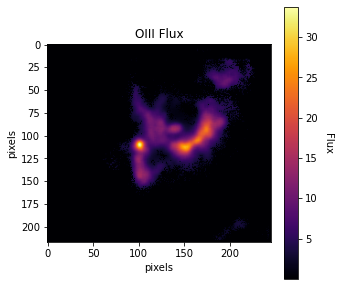

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=flux[0].data

plt.imshow(image_data, cmap='inferno')

ax.set_xlabel('pixels')
ax.set_ylabel('pixels')

cbar = plt.colorbar()
cbar.set_label('Flux', rotation=270, labelpad=15) 

plt.title('OIII Flux')

Matrix to List

In [14]:
flx=flux[0].data
df=pd.DataFrame(flx)
dffx=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})
dffx.describe()

,X,Y,I
count,53165.000000,53165.000000,5.316500e+04
mean,108.000000,122.000000,1.296366e+00
std,62.642428,70.725484,3.449498e+00
min,0.000000,0.000000,8.434807e-09
25%,54.000000,61.000000,8.434807e-09
50%,108.000000,122.000000,8.434807e-09
75%,162.000000,183.000000,8.434807e-09
max,216.000000,244.000000,3.374002e+01


Radial velocity map

Text(0.5, 1.0, 'OIII Radial Velocity')

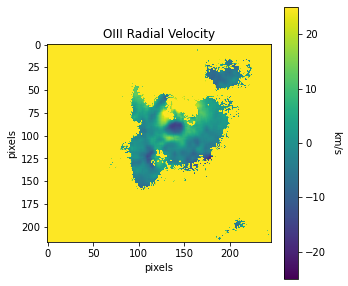

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=rad_vel[0].data

plt.imshow(image_data, cmap='viridis')

ax.set_xlabel('pixels')
ax.set_ylabel('pixels')

cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  
plt.clim(-25,25) 

plt.title('OIII Radial Velocity')

Matrix to List

In [16]:
vel=rad_vel[0].data
df=pd.DataFrame(vel)
dfvr=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
dfvr.describe()

,X,Y,RV
count,53165.000000,53165.000000,53165.000000
mean,108.000000,122.000000,159.964736
std,62.642428,70.725484,76.438049
min,0.000000,0.000000,-20.419067
25%,54.000000,61.000000,196.610001
50%,108.000000,122.000000,196.610001
75%,162.000000,183.000000,196.610001
max,216.000000,244.000000,196.610001


Sigma map

Text(0.5, 1.0, 'OIII σ')

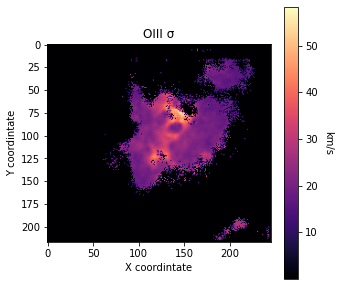

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

image_data=sigma[0].data

plt.imshow(image_data, cmap='magma')

ax.set_xlabel('X coordintate')
ax.set_ylabel('Y coordintate')

cbar = plt.colorbar()
cbar.set_label('km/s', rotation=270, labelpad=15)  

#plt.gca().invert_yaxis()
plt.title('OIII σ')

Matrix to list

In [18]:
sig=sigma[0].data
df=pd.DataFrame(sig)
dsig=df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'Sig'})
dsig.describe()

,X,Y,Sig
count,53165.000000,53165.000000,5.316500e+04
mean,108.000000,122.000000,4.433354e+00
std,62.642428,70.725484,9.644502e+00
min,0.000000,0.000000,1.457178e-08
25%,54.000000,61.000000,1.457178e-08
50%,108.000000,122.000000,1.457178e-08
75%,162.000000,183.000000,1.457178e-08
max,216.000000,244.000000,5.829112e+01


Merge previous lists

In [19]:
data=dfvr
data['I']=dffx.I
data['Sig']=dsig.Sig
data.describe()

,X,Y,RV,I,Sig
count,53165.000000,53165.000000,53165.000000,5.316500e+04,5.316500e+04
mean,108.000000,122.000000,159.964736,1.296366e+00,4.433354e+00
std,62.642428,70.725484,76.438049,3.449498e+00,9.644502e+00
min,0.000000,0.000000,-20.419067,8.434807e-09,1.457178e-08
25%,54.000000,61.000000,196.610001,8.434807e-09,1.457178e-08
50%,108.000000,122.000000,196.610001,8.434807e-09,1.457178e-08
75%,162.000000,183.000000,196.610001,8.434807e-09,1.457178e-08
max,216.000000,244.000000,196.610001,3.374002e+01,5.829112e+01


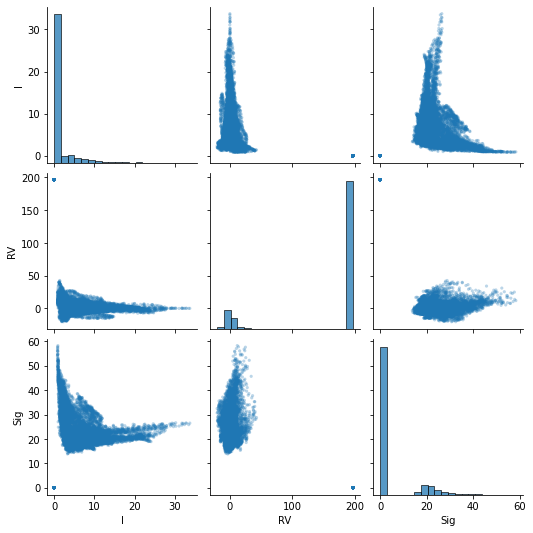

In [20]:
sns.pairplot(data, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

Clean data

In [21]:
#mI=(data.I>data.I.mean()+0.25*data.I.std())#&(data.Sig>data.Sig.mean()+0.5*data.Sig.std())
mI=(data.I>1)#&(data.Sig>1)
#mI=(data.Sig>5)
data2=data[mI]

In [22]:
data2.describe()

,X,Y,RV,I,Sig
count,9897.000000,9897.000000,9897.000000,9897.000000,9897.000000
mean,93.208144,146.945741,0.730744,6.958898,23.545748
std,36.528078,36.537505,7.338813,4.951539,6.093793
min,5.000000,61.000000,-20.419067,1.000305,13.826577
25%,68.000000,115.000000,-3.654755,3.431767,19.345448
50%,94.000000,144.000000,-0.436478,5.451309,21.800505
75%,118.000000,178.000000,4.039856,9.068021,26.026396
max,214.000000,242.000000,42.600693,33.740025,52.322945


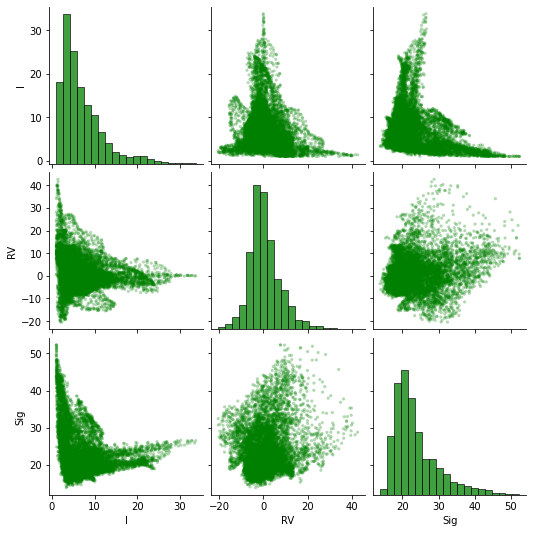

In [23]:
sns.pairplot(data2, 
             vars=["I","RV","Sig"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none',color='green'),
             diag_kws=dict(bins=20, color="green"),
            )

In [24]:
data.describe()

,X,Y,RV,I,Sig
count,53165.000000,53165.000000,53165.000000,5.316500e+04,5.316500e+04
mean,108.000000,122.000000,159.964736,1.296366e+00,4.433354e+00
std,62.642428,70.725484,76.438049,3.449498e+00,9.644502e+00
min,0.000000,0.000000,-20.419067,8.434807e-09,1.457178e-08
25%,54.000000,61.000000,196.610001,8.434807e-09,1.457178e-08
50%,108.000000,122.000000,196.610001,8.434807e-09,1.457178e-08
75%,162.000000,183.000000,196.610001,8.434807e-09,1.457178e-08
max,216.000000,244.000000,196.610001,3.374002e+01,5.829112e+01


standars errors

In [25]:
data2.sem()

X      0.367177
Y      0.367271
RV     0.073769
I      0.049772
Sig    0.061254
dtype: float64

Clean maps and other results

Text(0.5, 1.0, 'NGC 604')

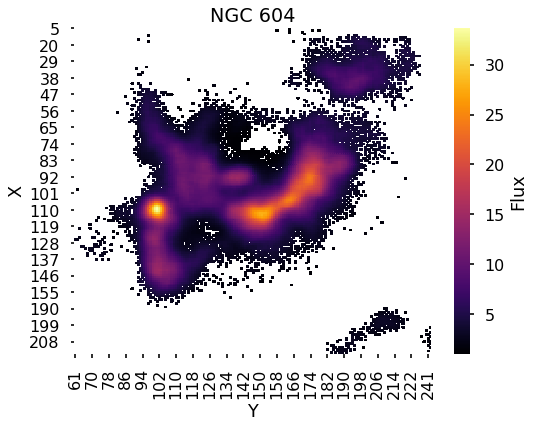

In [26]:
plt.style.use([
    "seaborn-poster",
])

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot()

datal=data2.copy()
#datal.I=np.log10(datal.I)

datal.X=datal.X.astype(int)
dataH_f=(datal.round(2)).pivot(index='X', columns='Y', values='I')
sns.heatmap(dataH_f, cmap="inferno",xticklabels='auto',cbar_kws={'label': 'Flux'})
#plt.title('H$_{α}$ Flux')
plt.title('NGC 604')

#plt.savefig('Imgs//Flux//N604.pdf', bbox_inches='tight')


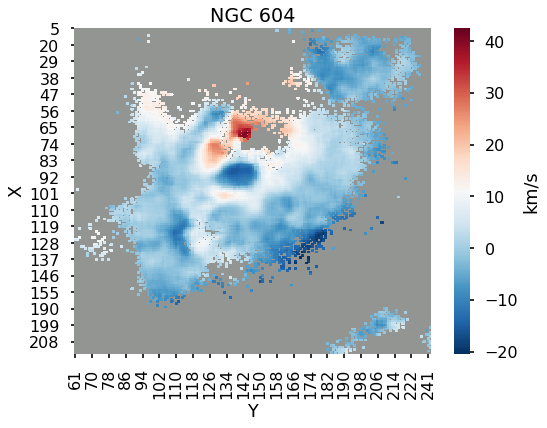

In [27]:
plt.style.use([
    "seaborn-poster",
])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

datal=data2.copy()

dataH_rv=(datal.round(2)).pivot(index='X', columns='Y', values='RV')
sns.heatmap(dataH_rv, cmap="RdBu_r",cbar_kws={'label': 'km/s'})
plt.title('NGC 604')
ax.set_facecolor('xkcd:gray')

#plt.axhline(y=20, xmin=0.05, xmax=0.39, linewidth=2, color = 'k')

#ax.text(0.32, 0.9, '60 pc',
#        verticalalignment='bottom', horizontalalignment='right',
#        transform=ax.transAxes,
#        color='black', fontsize=20)

#plt.savefig('Imgs//VF//N604.pdf', bbox_inches='tight')


Text(0.5, 1.0, 'H$_{α}$ σ')

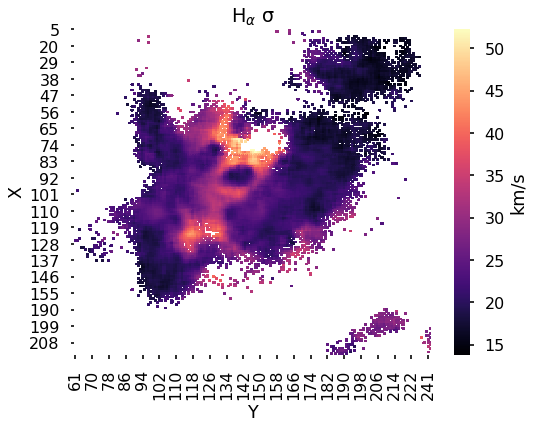

In [28]:
plt.style.use([
    "seaborn-poster",
])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

datal=data2.copy()

dataH_s=(datal).pivot(index='X', columns='Y', values='Sig')

sns.heatmap(dataH_s, cmap="magma",cbar_kws={'label': 'km/s'})
plt.title('H$_{α}$ σ')
#plt.gca().invert_yaxis()
#plt.savefig('TAURUS/Imgs/A/'+reg+'SH.png')

In [29]:
new_hdul = fits.HDUList()
new_hdul.append(fits.PrimaryHDU())
new_hdul.append(fits.ImageHDU(dataH_f))
new_hdul.append(fits.ImageHDU(dataH_rv))
new_hdul.append(fits.ImageHDU(dataH_s))

In [30]:
hdr = new_hdul[0].header

In [31]:
hdr ['CDELT1'] = (-pix / (60*60), '[deg] Coordinate increment at reference point')
hdr ['CDELT2'] = (pix / (60*60), '[deg] Coordinate increment at reference point')
hdr['CUNIT1']  = ('deg' , 'Units of coordinate increment and value' )      
hdr['CUNIT2']  = ('deg' , 'Units of coordinate increment and value'  )
hdr['CTYPE1']  = ('RA---CAR', 'Right ascension, plate caree projection  ')
hdr['CTYPE2']  = ('DEC--CAR', 'Declination, plate caree projection   ')
hdr['targname']  = ('NGC 604', 'Target name   ')
hdr['distance']  = (distance, 'Distance to target   ')
hdr['pix'] = (pix, 'arcsec.pixel^{-1}')

In [32]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CDELT1  = -7.2222222222222E-05 / [deg] Coordinate increment at reference point  
CDELT2  = 7.22222222222222E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg     '           / Units of coordinate increment and value        
CUNIT2  = 'deg     '           / Units of coordinate increment and value        
CTYPE1  = 'RA---CAR'           / Right ascension, plate caree projection        
CTYPE2  = 'DEC--CAR'           / Declination, plate caree projection            
TARGNAME= 'NGC 604 '           / Target name                                    
DISTANCE=               840000 / Distance to target                             
PIX     =                 0.

In [33]:
new_hdul.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1                1 ImageHDU         7   (170, 178)   float64   
  2                1 ImageHDU         7   (170, 178)   float64   
  3                1 ImageHDU         7   (170, 178)   float64   


In [34]:
#new_hdul.writeto(str(datapath_obs)+ '/' +name_export + '-mod.fits')

Sigma disp - deconvolution

In [35]:
data2['SigDisp']=(data2.Sig**2-2.28**2-13.4**2)**0.5

<ipython-input-35-cb8cdce20d7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['SigDisp']=(data2.Sig**2-2.28**2-13.4**2)**0.5


In [36]:
data2.describe()

,X,Y,RV,I,Sig,SigDisp
count,9897.000000,9897.000000,9897.000000,9897.000000,9897.000000,9897.000000
mean,93.208144,146.945741,0.730744,6.958898,23.545748,18.806932
std,36.528078,36.537505,7.338813,4.951539,6.093793,7.285538
min,5.000000,61.000000,-20.419067,1.000305,13.826577,2.532950
25%,68.000000,115.000000,-3.654755,3.431767,19.345448,13.765462
50%,94.000000,144.000000,-0.436478,5.451309,21.800505,17.044166
75%,118.000000,178.000000,4.039856,9.068021,26.026396,22.194929
max,214.000000,242.000000,42.600693,33.740025,52.322945,50.526549


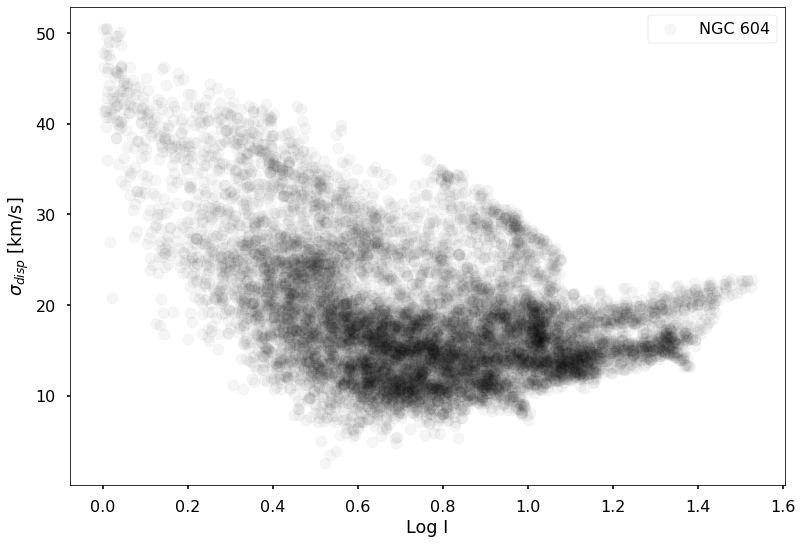

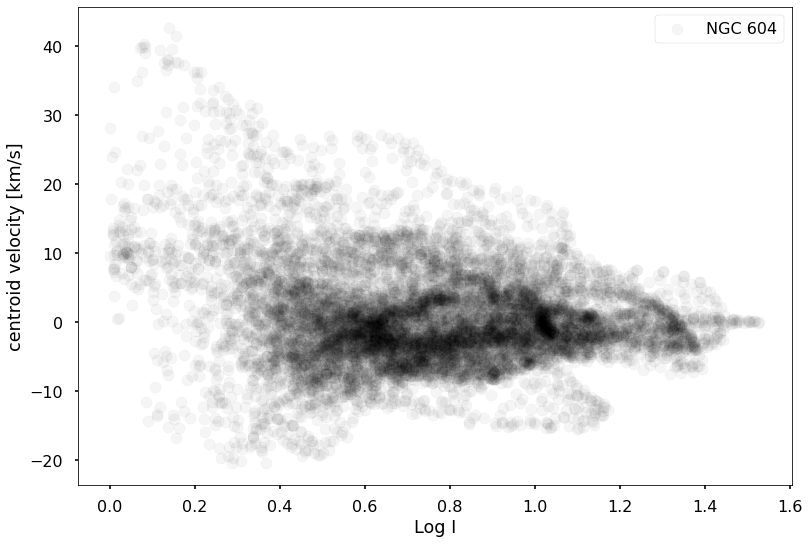

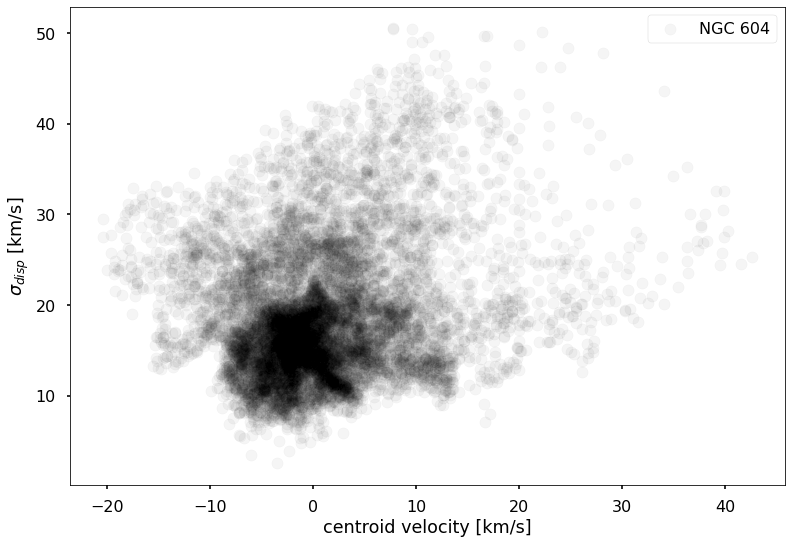

In [37]:
fig, ax = plt.subplots()
plt.scatter(np.log10(data2.I),data2.SigDisp, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(np.log10(data2.I),data2.RV, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('Log I')
ax.set_ylabel('centroid velocity [km/s]')
plt.legend()

fig, ax = plt.subplots()
plt.scatter(data2.RV,data2.SigDisp, alpha=0.04, color='k',label='NGC 604')

ax.set_xlabel('centroid velocity [km/s]')
ax.set_ylabel('$σ_{disp}$ [km/s]')
plt.legend()



Text(0.5, 6.799999999999979, 'Radial velocity [km/s]')

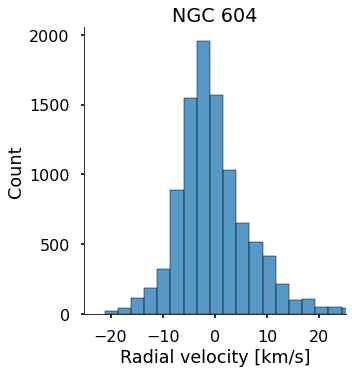

In [38]:
#fig, ax = plt.subplots()

sns.displot(data2.RV-data2.RV.mean(),bins=25)
plt.xlim(-25,25)

#plt.text(0.65, 1.20,'n ='+str(data.RV.count()), ha='center', va='center', transform=ax.transAxes, color='k')
#plt.text(0.70, 0.82,'$μ$ ='+str(np.round(data.RV.mean(),2))+' km/s', ha='center', va='center', transform=ax.transAxes, color='k')
#plt.text(0.65, 1.3,'$σ^{2}$ ='+str(np.round(data.RV.var(),2))+' km$^{2}$/s$^{2}$', ha='center', va='center', transform=ax.transAxes, color='k')

plt.title('NGC 604')

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

plt.xlabel('Radial velocity [km/s]')

Export data

In [39]:
data_export_list = {
        'name': name_export, 
        'pc' : pc,
        's0' : s0,
        'pix' : pix,
         name_export : np.array(data2),
      }
data_export_list

{'name': 'TAU-N604-O',
 'pc': 4.072434921320102,
 's0': 1.5563445559185105,
 'pix': 0.26,
 'TAU-N604-O': array([[  5.        , 164.        ,  -4.38618464,   1.27291489,
          30.01109695,  26.75644857],
        [  6.        , 158.        ,   0.55825812,   1.03964997,
          30.19504928,  26.96261488],
        [  6.        , 164.        ,  -4.09361264,   1.34772492,
          29.93946457,  26.67607803],
        ...,
        [214.        , 188.        ,   1.61151126,   2.69658376,
          24.50517084,  20.38982585],
        [214.        , 189.        ,   2.40147406,   2.64844513,
          24.40332415,  20.26730938],
        [214.        , 191.        ,   6.05859383,   2.53100015,
          22.9779854 ,  18.52645171]])}

In [40]:
data_export_matrix = {
       'name': name_export, 
       'pc' : pc,
       's0' : s0,
       'pix' : pix,
       'sb' :np.array(dataH_f),
       'vv' : np.array(dataH_rv),
       'ss' : np.array(dataH_s),

      }

data_export_matrix

{'name': 'TAU-N604-O',
 'pc': 4.072434921320102,
 's0': 1.5563445559185105,
 'pix': 0.26,
 'sb': array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan, 1.59,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]]),
 'vv': array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan, -2.63,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]),
 'ss': array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 

In [41]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [42]:
jsonfilename =name_export +"-m.json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(data_export_matrix, fp=f, indent=3, cls=MyEncoder)

In [43]:
jsonfilename =name_export +"-l.json"
with open(datapath_res/jsonfilename, "w") as f:
    json.dump(data_export_list, fp=f, indent=3, cls=MyEncoder)

In [44]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 14.963637828826904 seconds ---


In [45]:
!jupyter nbconvert --to script --no-prompt otv-TAU-N604-O.ipynb

[NbConvertApp] Converting notebook otv-TAU-N604-O.ipynb to script
[NbConvertApp] Writing 7240 bytes to otv-TAU-N604-O.py
